In [21]:
!pip install transformers datasets evaluate timm captum --quiet

In [18]:
import os
# 1) Early opt‑out for the env var
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"

import random
import torch
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from io import BytesIO
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup
import timm
from torch.optim import AdamW


# 1) Fix seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# 2) Config
config = {
    "dataset_name":     "cifar100",
    "num_labels":       100,
    "train_frac":       0.80,
    "val_frac":         0.10,
    "holdout_frac":     0.10,
    "batch_size_train": 128,
    "batch_size_val":   256,
    "max_epochs":       25,
    "patience":         5,
    "warmup_epochs":    3,
    "lr":               5e-5,
    "weight_decay":     0.05,
    "output_dir":       "./vit-cifar100-checkpoints",
}
os.makedirs(config["output_dir"], exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# 1) Load & split
ds = load_dataset(config["dataset_name"])["train"]
split1 = ds.train_test_split(test_size=config["holdout_frac"], seed=seed)
tmp, holdout_ds = split1["train"], split1["test"]

val_prop = config["val_frac"] / (config["train_frac"] + config["val_frac"])
split2   = tmp.train_test_split(test_size=val_prop, seed=seed)
train_ds, val_ds = split2["train"], split2["test"]

# 2) Transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# 3) Robust preprocess helper
def preprocess(example, train=True):
    img = example["img"]
    if isinstance(img, (bytes, bytearray)):
        img = Image.open(BytesIO(img))
    if isinstance(img, list):
        img = img[0]
        if isinstance(img, (bytes, bytearray)):
            img = Image.open(BytesIO(img))
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    img = img.convert("RGB")
    example["pixel_values"] = (train and train_tf or eval_tf)(img)
    example["labels"] = example["fine_label"]
    return example

# 4) Map & format (no progress bars will appear)
train_ds   = train_ds.map(lambda x: preprocess(x, True),    remove_columns=["img"])
val_ds     = val_ds.map(lambda x:   preprocess(x, False),   remove_columns=["img"])
holdout_ds = holdout_ds.map(lambda x: preprocess(x, False), remove_columns=["img"])
for d in (train_ds, val_ds, holdout_ds):
    d.set_format("torch", columns=["pixel_values","labels"])

# 5) Dataloaders
train_loader   = DataLoader(train_ds,    batch_size=config["batch_size_train"],
                            shuffle=True,  num_workers=4)
val_loader     = DataLoader(val_ds,      batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=4)
holdout_loader = DataLoader(holdout_ds,  batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=4)

print(f"Train/Val/Holdout sizes: {len(train_ds)}/{len(val_ds)}/{len(holdout_ds)}")

Train/Val/Holdout sizes: 40000/5000/5000


# Base Model

## 1 - Fine-tuning

In [ ]:
# 1) Model init (swap in your DyT version here when ready)
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=config["num_labels"])
model.to(device)

# 2) Optimizer, loss, mixed‑precision scaler
optimizer = AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
criterion = nn.CrossEntropyLoss()
scaler    = torch.cuda.amp.GradScaler()

# 3) LR schedule: warmup → cosine decay
total_steps   = len(train_loader) * config["max_epochs"]
warmup_steps  = len(train_loader) * config["warmup_epochs"]
scheduler     = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# 4) Training + early stopping
best_val_acc, wait = 0.0, 0
for epoch in range(1, config["max_epochs"]+1):
    # — train
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # — validate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            preds = model(inputs).argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # — early stop & checkpoint
    if val_acc > best_val_acc:
        best_val_acc, wait = val_acc, 0
        ckpt_path = os.path.join(config["output_dir"], "best_val_acc.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f" → new best, saved to {ckpt_path}")
    else:
        wait += 1
        if wait >= config["patience"]:
            print("Early stopping triggered.")
            break

## 2 - Interpretability

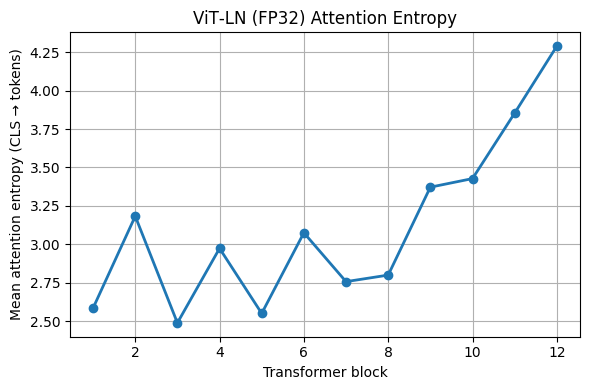

In [17]:
# Cell Z: Attention‑entropy via direct hook on Attention.forward
import os, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load your best‐val checkpoint
model_ln = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"])
model_ln.load_state_dict(torch.load(os.path.join(config["output_dir"], "best_val_acc.pt")))
model_ln.eval().to(device)

# 2) Prepare accumulators
num_layers  = len(model_ln.blocks)
entropy_sum = torch.zeros(num_layers)
sample_cnt  = torch.zeros(num_layers)
eps = 1e-12

# 3) Hook that re‐computes attention inside each block
def make_hook(layer_idx):
    def hook(module, inp, out):
        # inp[0] is the block input x: [B, N, C]
        x = inp[0]
        B, N, C = x.shape
        # produce q, k
        qkv = module.qkv(x)                                    # [B, N, 3*C]
        head_dim = C // module.num_heads
        qkv = qkv.reshape(B, N, 3, module.num_heads, head_dim) # [B,N,3,heads,hd]
        qkv = qkv.permute(2, 0, 3, 1, 4)                       # [3,B,heads,N,hd]
        q, k, v = qkv[0], qkv[1], qkv[2]                       # each [B,heads,N,hd]
        # scaled dot‐product
        attn = (q @ k.transpose(-2, -1)) * module.scale       # [B,heads,N,N]
        attn = attn.softmax(dim=-1)                           # probabilities
        # extract class‐token row
        cls_attn = attn[:, :, 0, :]                           # [B, heads, N]
        # entropy per head per sample
        ent = -(cls_attn * (cls_attn + eps).log()).sum(-1)    # [B, heads]
        entropy_sum[layer_idx] += ent.sum().cpu()
        sample_cnt[layer_idx]  += ent.numel()
    return hook

# 4) Register hooks on each Attention module
hooks = []
for i, blk in enumerate(model_ln.blocks):
    hooks.append(blk.attn.register_forward_hook(make_hook(i)))

# 5) Run a forward pass on the validation set (no grad)
with torch.no_grad():
    for batch in val_loader:
        imgs = batch["pixel_values"].to(device)
        _ = model_ln(imgs)

# 6) Clean up hooks and compute mean entropy
for h in hooks: h.remove()
mean_entropy = entropy_sum / sample_cnt  # shape [num_layers]

# 7) Plot
layers = list(range(1, num_layers+1))
plt.figure(figsize=(6,4))
plt.plot(layers, mean_entropy.numpy(), marker="o", linewidth=2)
plt.xlabel("Transformer block")
plt.ylabel("Mean attention entropy (CLS → tokens)")
plt.title("ViT‑LN (FP32) Attention Entropy")
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_entropy_ln_fp32.png", dpi=150)
plt.show()

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from captum.attr import Saliency
import timm

def load_fp32_models(ckpt_path, num_labels, device):
    """
    Returns a tuple (model_gpu, model_cpu, saliency_cpu).
    - model_gpu: loaded on `device`, used for forward → pred
    - model_cpu: loaded on CPU, used for saliency backward
    - saliency_cpu: Captum Saliency wrapped around model_cpu
    """
    # instantiate both
    model_gpu = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=num_labels
    )
    model_cpu = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=num_labels
    )
    # load checkpoint onto CPU
    state = torch.load(ckpt_path, map_location="cpu")
    model_gpu.load_state_dict(state)
    model_cpu.load_state_dict(state)
    # free raw state dict
    del state
    torch.cuda.empty_cache()
    # move GPU model to device
    model_gpu.eval().to(device)
    # keep CPU model on cpu
    model_cpu.eval().to("cpu")
    saliency_cpu = Saliency(model_cpu)
    return model_gpu, model_cpu, saliency_cpu

def compute_fp32_focus(
    ckpt_path,
    val_ds,
    device,
    max_images=500,
    pct=0.05,
    num_workers=2
):
    """
    Computes saliency‐density focus scores for the FP32 model.
    Returns (mean_focus, std_focus).
    """
    # 1) Prepare models & saliency
    model_gpu, model_cpu, saliency_cpu = load_fp32_models(
        ckpt_path, num_labels=config["num_labels"], device=device
    )

    # 2) Single‐image DataLoader
    loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=num_workers)

    # 3) Loop & accumulate
    focus_scores = []
    processed = 0
    for batch in loader:
        inp_gpu = batch["pixel_values"].to(device)
        with torch.no_grad():
            out  = model_gpu(inp_gpu)
            pred = out.argmax(dim=-1).cpu()

        inp_cpu = inp_gpu.cpu().detach().requires_grad_()
        grad_cpu = saliency_cpu.attribute(inp_cpu, target=pred)

        sal_map = grad_cpu.abs().max(1)[0].squeeze(0).numpy()
        flat    = sal_map.ravel()
        thr     = np.percentile(flat, 100*(1-pct))
        focus_scores.append((flat >= thr).sum() / flat.size)

        processed += 1
        if processed >= max_images:
            break

    # 4) Compute stats
    mean_focus = np.mean(focus_scores)
    std_focus  = np.std(focus_scores)
    return mean_focus, std_focus

In [32]:
ckpt_path = os.path.join(config["output_dir"], "best_val_acc.pt")
mean_fp32, std_fp32 = compute_fp32_focus(ckpt_path, val_ds, device)

print(f"Processed up to {min(len(val_ds), 500)} images")
print(f"FP32 focus (top {int(0.05*100)}% pixels): {mean_fp32:.4f} ± {std_fp32:.4f}")

Processed 500 images
ViT‑LN FP32 focus (top 5% pixels): 0.0500 ± 0.0000
